# Lab Assignment 10: Exploratory Data Analysis, Part 1
## DS 6001: Practice and Application of Data Science

### Emily Lien, egl6a

### Instructions
Please answer the following questions as completely as possible using text, code, and the results of code as needed. Format your answers in a Jupyter notebook. To receive full credit, make sure you address every part of the problem, and make sure your document is formatted in a clean and professional way.

In this lab, you will be working with the 2018 [General Social Survey (GSS)](http://www.gss.norc.org/). The GSS is a sociological survey created and regularly collected since 1972 by the National Opinion Research Center at the University of Chicago. It is funded by the National Science Foundation. The GSS collects information and keeps a historical record of the concerns, experiences, attitudes, and practices of residents of the United States, and it is one of the most important data sources for the social sciences. 

The data includes features that measure concepts that are notoriously difficult to ask about directly, such as religion, racism, and sexism. The data also include many different metrics of how successful a person is in his or her profession, including income, socioeconomic status, and occupational prestige. These occupational prestige scores are coded separately by the GSS.  The full description of their methodology for measuring prestige is available here: http://gss.norc.org/Documents/reports/methodological-reports/MR122%20Occupational%20Prestige.pdf Here's a quote to give you an idea about how these scores are calculated:

> Respondents then were given small cards which each had a single occupational titles listed on it. Cards were in English or Spanish. They were given one card at a time in the preordained order. The interviewer then asked the respondent to "please put the card in the box at the top of the ladder if you think that occupation has the highest possible social standing. Put it in the box of the bottom of the ladder if you think it has the lowest possible social standing. If it belongs somewhere in between, just put it in the box that matches the social standing of the occupation."

The prestige scores are calculated from the aggregated rankings according to the method described above.

### Problem 0
Import the following packages:

Breakout room 2

In [6]:
import numpy as np
import pandas as pd
import sidetable
import weighted # this is a module of wquantiles, so type pip install wquantiles or conda install wquantiles to get access to it
from scipy import stats 
from sklearn import manifold
from sklearn import metrics
import prince
from pandas_profiling import ProfileReport
pd.options.display.max_columns = None

ModuleNotFoundError: No module named 'pandas_profiling'

In [7]:
!pip install pandas_profiling

  Created wheel for phik: filename=phik-0.11.0-py3-none-any.whl size=599743 sha256=e32b388263ab7ac01716864ffa75af52a9229b351312d904f7ff163e294dcbbd
  Stored in directory: c:\users\elfda\appdata\local\pip\cache\wheels\15\cd\d8\d1a2da5bf20e6411649edb390d93887820168898a3659fd48d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27091 sha256=8605494d9c9980a10424045c54a2ebc4cc0c2f01b3000d78498651e56d3fdbc6
  Stored in directory: c:\users\elfda\appdata\local\pip\cache\wheels\23\14\6e\4be5bfeeb027f4939a01764b48edd5996acf574b0913fe5243
Successfully built phik htmlmin


Then load the GSS data with the following code:

In [5]:
%%capture
gss = pd.read_csv("https://github.com/jkropko/DS-6001/raw/master/localdata/gss2018.csv",
                 encoding='cp1252', na_values=['IAP','IAP,DK,NA,uncodeable', 'NOT SURE',
                                               'DK', 'IAP, DK, NA, uncodeable', '.a', "CAN'T CHOOSE"])

### Problem 1
Drop all columns except for the following:
* `id` - a numeric unique ID for each person who responded to the survey
* `wtss` - survey sample weights
* `sex` - male or female
* `educ` - years of formal education
* `region` - region of the country where the respondent lives
* `age` - age
* `coninc` - the respondent's personal annual income
* `prestg10` - the respondent's occupational prestige score, as measured by the GSS using the methodology described above
* `mapres10` - the respondent's mother's occupational prestige score, as measured by the GSS using the methodology described above
* `papres10` -the respondent's father's occupational prestige score, as measured by the GSS using the methodology described above
* `sei10` - an index measuring the respondent's socioeconomic status
* `satjob` - responses to "On the whole, how satisfied are you with the work you do?"
* `fechld` - agree or disagree with: "A working mother can establish just as warm and secure a relationship with her children as a mother who does not work."
* `fefam` - agree or disagree with: "It is much better for everyone involved if the man is the achiever outside the home and the woman takes care of the home and family."
* `fepol` - agree or disagree with: "Most men are better suited emotionally for politics than are most women."
* `fepresch` - agree or disagree with: "A preschool child is likely to suffer if his or her mother works."
* `meovrwrk` - agree or disagree with: "Family life often suffers because men concentrate too much on their work."

Then rename any columns with names that are non-intuitive to you to more intuitive and descriptive ones. Finally, replace the "89 or older" values of `age` with 89, and convert `age` to a float data type. [1 point]

In [6]:
gssTrim=gss[['id','wtss','sex','educ','region','age','coninc','prestg10','mapres10','papres10','sei10','satjob','fechld','fefam','fepol','fepresch','meovrwrk']]

In [17]:
#Well, I WANTED to used these, but then the profile report won't run
gssTrim.columns=[['id','weights','sex','education','region','age','income','job_prestige','ma_job_prestige','pa_job_prestige',
                 'socio_ec_status','job_satisfaction','working_moms_rule','50s_bull','what_century_is_this','your_kid_will_be_fine',
                 'dads_eaten_by_work']]

In [7]:
gssTrim=gssTrim.replace({'age':{'89 or older': 89}})

In [8]:
gssTrim

id      wtss     sex  educ       region age       coninc  prestg10  \
0        1  2.357493    male  14.0  new england  43          NaN      47.0   
1        2  0.942997  female  10.0  new england  74   22782.5000      22.0   
2        3  0.942997    male  16.0  new england  42  112160.0000      61.0   
3        4  0.942997  female  16.0  new england  63  158201.8412      59.0   
4        5  0.942997    male  18.0  new england  71  158201.8412      53.0   
...    ...       ...     ...   ...          ...  ..          ...       ...   
2343  2344  0.471499  female  12.0  new england  37          NaN      47.0   
2344  2345  0.942997  female  12.0  new england  75   22782.5000      28.0   
2345  2346  0.942997  female  12.0  new england  67   70100.0000      40.0   
2346  2347  0.942997    male  16.0  new england  72   38555.0000      47.0   
2347  2348  0.471499  female  12.0  new england  79          NaN      33.0   

      mapres10  papres10  sei10          satjob             fechld  \
0         31.0      45.0   65.3  very satisfied     strongly agree   
1         32.0      39.0   14.8             NaN                NaN   
2         32.0      72.0   83.4  mod. satisfied     strongly agree   
3          NaN      39.0   69.3  very satisfied              agree   
4         35.0      45.0   68.6             NaN                NaN   
...        ...       ...    ...             ...                ...   
2343      31.0      72.0   38.8  mod. satisfied           disagree   
2344       NaN      27.0   21.6  very satisfied     strongly agree   
2345      45.0      53.0   41.8             NaN                NaN   
2346      53.0      50.0   62.7             NaN           disagree   
2347       NaN      46.0   13.6  very satisfied  strongly disagree   

                  fefam     fepol           fepresch  \
0              disagree     agree  strongly disagree   
1                   NaN       NaN                NaN   
2              disagree  disagree           disagree   
3              disagree  disagree           disagree   
4                   NaN       NaN                NaN   
...                 ...       ...                ...   
2343  strongly disagree  disagree  strongly disagree   
2344           disagree  disagree           disagree   
2345                NaN       NaN                NaN   
2346              agree  disagree     strongly agree   
2347     strongly agree  disagree     strongly agree   

                        meovrwrk  
0                          agree  
1                            NaN  
2                       disagree  
3     neither agree nor disagree  
4                            NaN  
...                          ...  
2343                    disagree  
2344                    disagree  
2345                         NaN  
2346                       agree  
2347              strongly agree  

[2348 rows x 17 columns]

In [9]:
gssTrim=gssTrim.astype({'age':'float64'})

In [10]:
gssTrim.head()

id      wtss     sex  educ       region   age       coninc  prestg10  \
0   1  2.357493    male  14.0  new england  43.0          NaN      47.0   
1   2  0.942997  female  10.0  new england  74.0   22782.5000      22.0   
2   3  0.942997    male  16.0  new england  42.0  112160.0000      61.0   
3   4  0.942997  female  16.0  new england  63.0  158201.8412      59.0   
4   5  0.942997    male  18.0  new england  71.0  158201.8412      53.0   

   mapres10  papres10  sei10          satjob          fechld     fefam  \
0      31.0      45.0   65.3  very satisfied  strongly agree  disagree   
1      32.0      39.0   14.8             NaN             NaN       NaN   
2      32.0      72.0   83.4  mod. satisfied  strongly agree  disagree   
3       NaN      39.0   69.3  very satisfied           agree  disagree   
4      35.0      45.0   68.6             NaN             NaN       NaN   

      fepol           fepresch                    meovrwrk  
0     agree  strongly disagree                       agree  
1       NaN                NaN                         NaN  
2  disagree           disagree                    disagree  
3  disagree           disagree  neither agree nor disagree  
4       NaN                NaN                         NaN

### Problem 2
#### Part a
Use the `ProfileReport()` function to generate and embed an HTML formatted exploratory data analysis report in your notebook. Make sure that it includes a "Correlations" report along with "Overview" and "Variables". [1 point]

In [28]:
profile = ProfileReport(gssTrim, 
                        title='Pandas Profiling Report',
                        html={'style':{'full_width':True}},
                       minimal=False)
profile.to_notebook_iframe()

#### Part b
Looking through the HTML report you displayed in part a, how many people in the data are from New England? [1 point]

124

#### Part c
Looking through the HTML report you displayed in part a, which feature in the data has the highest number of missing values, and what percent of the values are missing for this feature? [1 point]

fepol has 849 (36.2%) missing values 

#### Part d
Looking through the HTML report you displayed in part a, which two distinct features in the data have the highest correlation? [1 point]

prestg10 and sei10 have a correlation of about .8

### Problem 3
On a primetime show on a 24-hour cable news network, two unpleasant-looking men in suits sit across a table from each other, scowling. One says "This economy is failing the middle-class. The average American today is making less than \\$48,000 a year." The other screams "Fake news! The typical American makes more than \$55,000 a year!" Explain, using words and code, how the data can support both of their arguments. Use the sample weights to calculate descriptive statistics that are more representative of the American adult population as a whole. [1 point]

Depending on how you define the average American (statistical average, or the middle of the pack(median)?), this could produce different numbers. How the average is calculated (weighted or unweighted) would also affect what we perceive as the "average" American.

median=38555
Mean=49973.96078

In [12]:
#Weighted mean
gssNoNa=gssTrim.loc[~gssTrim.coninc.isna()]
np.average(gssNoNa['coninc'],weights=gssNoNa['wtss'])

55158.96280421564

### Problem 4
For each of the following parts, 
* generate a table that provides evidence about the relationship between the two features in the data that are relevant to each question, 
* interpret the table in words, 
* use a hypothesis test to assess the strength of the evidence in the table, 
* and provide a **specific and accurate** intepretation of the $p$-value associated with this hypothesis test beyond "significant or not". 

#### Part a
Is there a gender wage gap? That is, is there a difference between the average incomes of men and women? [2 points]

In [21]:
gssTrim.groupby('sex').agg({'coninc':'mean'}).round(2)

coninc
sex             
female  47191.02
male    53314.63

The above table shows the average individual income split between male and female

In [22]:
income_men = gssTrim.query("sex=='male'").coninc.dropna()
income_women = gssTrim.query("sex=='female'").coninc.dropna()

In [23]:
stats.ttest_ind(income_men, income_women, equal_var=False)

Ttest_indResult(statistic=3.332824087618215, pvalue=0.0008749557881530089)

The p-value suggests that we reject the null hypothesis of both means being equal and conclude a statistically significant difference between the average income for men and women. The smaller value of our test statistic suggests that it is not a very strong difference.

#### Part b
Are there different average values of occupational prestige for different levels of job satisfaction? [2 points]

In [24]:
gssTrim.groupby('satjob').agg({'prestg10':'mean'})

prestg10
satjob                      
a little dissat    40.946429
mod. satisfied     42.589984
very dissatisfied  43.000000
very satisfied     46.189320

The table shows a breakdown of average job prestige scores by job satisfaction responses.

In [13]:
stats.f_oneway(gssTrim.query("satjob=='a little dissat'").prestg10.dropna(),
               gssTrim.query("satjob=='mod. satisfied'").prestg10.dropna(),
               gssTrim.query("satjob=='very dissatisfied'").prestg10.dropna(),
               gssTrim.query("satjob=='very satisfied'").prestg10.dropna())

F_onewayResult(statistic=12.205403153509732, pvalue=6.676686425029878e-08)

Here, we have stronger evidence in addition to a small p-value that suggests average prestige is different among levels of job satisfaction.

### Problem 5
Report the Pearson's correlation between years of education, socioeconomic status, income, occupational prestige, and a person's mother's and father's occupational prestige? Then perform a hypothesis test for the correlation between years of education and socioeconomic status and provide a **specific and accurate** intepretation of the $p$-value associated with this hypothesis test beyond "significant or not". [2 points]

In [14]:
gssTrim[['educ','sei10','coninc','prestg10','mapres10','papres10']].corr()

educ     sei10    coninc  prestg10  mapres10  papres10
educ      1.000000  0.558169  0.389245  0.479933  0.269115  0.261417
sei10     0.558169  1.000000  0.417210  0.835515  0.203486  0.210451
coninc    0.389245  0.417210  1.000000  0.340995  0.164881  0.171048
prestg10  0.479933  0.835515  0.340995  1.000000  0.189262  0.192180
mapres10  0.269115  0.203486  0.164881  0.189262  1.000000  0.235750
papres10  0.261417  0.210451  0.171048  0.192180  0.235750  1.000000

In [15]:
gssCor = gssTrim[['educ', 'sei10']].dropna()
stats.pearsonr(gssCor['educ'], gssCor['sei10'])

(0.5581686004626785, 3.7194488100173034e-184)

This p-value means that the probability of a random sample producing a correlation of .558 between years of education and socioeconomic status if the true correlation is zero is very, very small. We conclude that there is a nonzero correlation between years of educaton and socioeconomic status.

### Problem 6
Create a new categorical feature for age groups, with categories for 18-35, 36-49, 50-69, and 70 and older (see the module 8 notebook for an example of how to do this). 

Then create a cross-tabulation in which the rows represent age groups and the columns represent responses to the statement that "It is much better for everyone involved if the man is the achiever outside the home and the woman takes care of the home and family." Rearrange the columns so that they are in the following order: strongly agree, agree, disagree, strongly disagree. Place row percents in the cells of this table.

Finally, use a hypothesis test that can tell use whether there is enough evidence to conclude that these two features have a relationship, and provide a specific and accurate intepretation of the $p$-value. [2 points]

In [16]:
gssTrim2=gssTrim.assign(age_groups=pd.cut(gssTrim.age,bins=[17,35,49,69,100],labels=["18-35","36-49","50-69","70 and up"]))

In [18]:
gsscross=pd.crosstab(gssTrim2.age_groups,gssTrim2.fefam,normalize=True)*100
gsscross=gsscross[['strongly agree','agree','disagree','strongly disagree']]
gsscross

fefam       strongly agree     agree   disagree  strongly disagree
age_groups                                                        
18-35             1.040312  3.706112  12.548765           9.102731
36-49             1.105332  4.031209  10.728218           7.217165
50-69             1.560468  7.022107  16.189857           8.907672
70 and up         2.015605  5.331599   6.566970           2.925878

In [19]:
stats.chi2_contingency(gsscross.values)

(4.502198804806119,
 0.8753687619250256,
 9,
 array([[ 1.51041411,  5.30361319, 12.15196809,  7.43192399],
        [ 1.32068229,  4.63739577, 10.62548934,  6.49835718],
        [ 1.92708007,  6.7666789 , 15.50423515,  9.48210991],
        [ 0.96354004,  3.38333945,  7.75211757,  4.74105496]]))

My p-value from the Chi-squared test indicates that we cannot reject the possibility that the differences between responses based on age are 0.

### Problem 7
For this problem, you will conduct and interpret a correspondence analysis on the categorical features that ask respondents to state the extent to which they agree or disagree with the statements:
* "A working mother can establish just as warm and secure a relationship with her children as a mother who does not work."
* "It is much better for everyone involved if the man is the achiever outside the home and the woman takes care of the home and family."
* "Most men are better suited emotionally for politics than are most women."
* "A preschool child is likely to suffer if his or her mother works."
* "Family life often suffers because men concentrate too much on their work."

#### Part a
Conduct a correspondence analysis using the observed features listed above that measures two latent features. Plot the two latent categories for each category in each of the features used in the analysis. [2 points]

In [20]:
gss7a=gssTrim2[['fefam','fechld','fepol','fepresch','meovrwrk']]

In [21]:
gss7a=gss7a.dropna()

In [22]:
mca=prince.MCA(
n_components=2
)
mca=mca.fit(gss7a)

In [23]:
mca.row_coordinates(gss7a)

0         1
0    -0.202209  0.338296
2    -0.423360 -0.316910
3    -0.195576 -0.648698
5    -0.240092 -0.298099
8     0.341539  0.091194
...        ...       ...
2341  1.219020  0.567426
2343 -0.521777  0.384975
2344 -0.423360 -0.316910
2346  1.076900  0.642136
2347  1.440616  2.529633

[1454 rows x 2 columns]

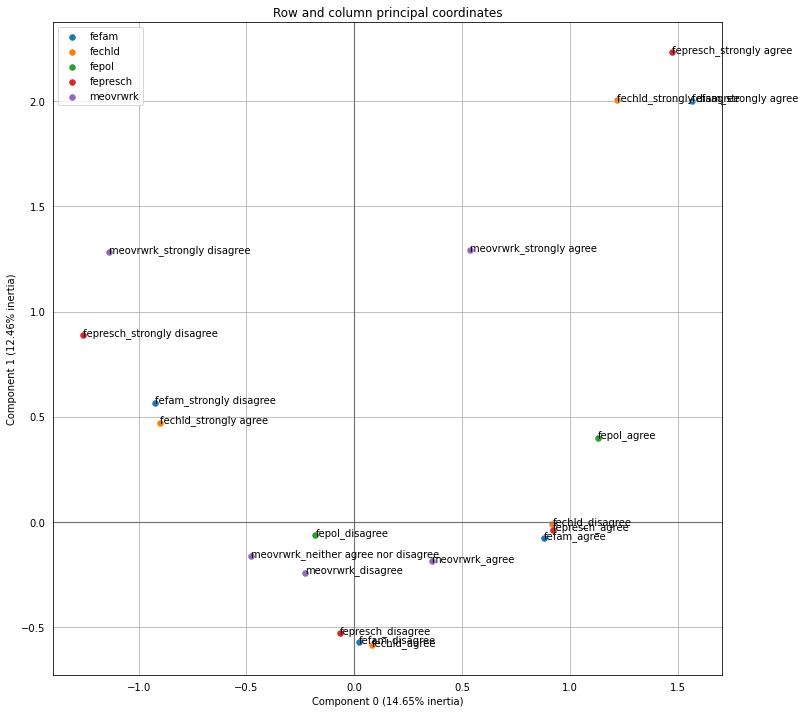

In [24]:
ax = mca.plot_coordinates(
     X=gss7a,
     ax=None,
     figsize=(12, 12),
     show_row_points=False,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=True,
     legend_n_cols=1
 )


#### Part b
Display the latent features for every category in the observed features, sorted by the first latent feature. Describe in words what concept this feature is attempting to measure, and give the feature a name. [2 points]

In [43]:
association=mca.column_coordinates(gss7a).sort_values(0)
association.head()

0         1
fepresch_strongly disagree          -1.258060  0.886699
meovrwrk_strongly disagree          -1.135402  1.283818
fefam_strongly disagree             -0.922035  0.566819
fechld_strongly agree               -0.901118  0.472176
meovrwrk_neither agree nor disagree -0.480747 -0.163822

Latent variable 0 seems to be a measure of feminist vs. patriarchal ideals, with stronger feminist ideals being represented by negative values. 

In [37]:
association.columns=[['feminist_index','1']]

#### Part c
We can use the results of the MCA model to conduct some cool EDA. For one example, follow these steps:

1. Use the `.row_coordinates()` method to calculate values of the latent feature for every row in the data you passed to the MCA in part a. Extract the first column and store it in its own dataframe.

2. To join it with the full, cleaned GSS data based on row numbers (instead of on a primary key), use the `.join()` method. For example, if we named the cleaned GSS data `gss_clean` and if we named the dataframe in step 1 `latentfeature`, we can type
```
gss_clean = gss_clean.join(latentfeature, how="outer")
```
3. Create a cross-tabuation with age categories (that you constructed in problem 5) in the rows and sex in the columns. Instead of a frequency, place the mean value of the latent feature in the cells. 

What does this table tell you about the relationship between sex, age, and the latent feature? [2 points]

In [42]:
col0=pd.DataFrame(mca.row_coordinates(gss7a)[0])
col0.columns=['feminist_index']
col0.head()

feminist_index
0       -0.202209
2       -0.423360
3       -0.195576
5       -0.240092
8        0.341539

In [44]:
gss7c=gssTrim2.join(col0,how="outer")
gss7c.head()

id      wtss     sex  educ       region   age       coninc  prestg10  \
0   1  2.357493    male  14.0  new england  43.0          NaN      47.0   
1   2  0.942997  female  10.0  new england  74.0   22782.5000      22.0   
2   3  0.942997    male  16.0  new england  42.0  112160.0000      61.0   
3   4  0.942997  female  16.0  new england  63.0  158201.8412      59.0   
4   5  0.942997    male  18.0  new england  71.0  158201.8412      53.0   

   mapres10  papres10  sei10          satjob          fechld     fefam  \
0      31.0      45.0   65.3  very satisfied  strongly agree  disagree   
1      32.0      39.0   14.8             NaN             NaN       NaN   
2      32.0      72.0   83.4  mod. satisfied  strongly agree  disagree   
3       NaN      39.0   69.3  very satisfied           agree  disagree   
4      35.0      45.0   68.6             NaN             NaN       NaN   

      fepol           fepresch                    meovrwrk age_groups  \
0     agree  strongly disagree                       agree      36-49   
1       NaN                NaN                         NaN  70 and up   
2  disagree           disagree                    disagree      36-49   
3  disagree           disagree  neither agree nor disagree      50-69   
4       NaN                NaN                         NaN  70 and up   

   feminist_index  
0       -0.202209  
1             NaN  
2       -0.423360  
3       -0.195576  
4             NaN

In [46]:
gsscross7=pd.crosstab(gss7c.age_groups,gss7c.sex,values=gss7c.feminist_index,aggfunc='mean')
gsscross7

sex           female      male
age_groups                    
18-35      -0.241140 -0.003774
36-49      -0.137001 -0.000686
50-69      -0.125059  0.222532
70 and up   0.129256  0.473006

This tells me that the older you are, especially if you identify as male, the more likely it is you lean towards older, patriarchal ideals (eh, not new information to me, really)